In [2]:
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.preprocessing.image import img_to_array
from keras._tf_keras.keras.utils import to_categorical, plot_model
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

hi


In [4]:
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96,96,3) # Height, width, num of RGB channels

In [8]:
data = []
labels = []

# Reading in images from dataset
# Bigger dataset: /Users/vasudevnair113/Downloads/faceRecog/archive
# Bigger dataset: /Users/vasudevnair113/Downloads/faceRecog/archiveSmall2
image_files = [f for f in glob.glob(r'/Users/saanvilukka/Documents/GitHub/ASL-Detector/asl_alphabet_train' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [9]:
# Adds images to array, also gives it a label (1 = female, 0 = male)
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0], img_dims[1])) # Resizes every image to be the same size
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    label = ord(label) - ord('A') # Convert label to numerical value (0-25)
    labels.append([label])

# Data pre-processing, converts data and labels to numpy array
try:
    data = np.array(data, dtype='float') / 255.0
    labels = np.array(labels)
except Exception as e:
    print(f"Error converting data to numpy array: {e}")


In [11]:
# Splits dataset into training and testing
# test_size = 0.2 means that 20% of the dataset will be used for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.2, random_state=42)

trainY = to_categorical(trainY, num_classes=26)
testY = to_categorical(testY, num_classes=26)

# Augmentation of dataset
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

In [13]:
# Height and width of image (96 x 96)
# Depth is RGB values
# Classes is number of categories (2 in our case because male/female)
def build(height, width, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # Need to check whether channels are first or last
    if K.image_data_format() == 'channels_first':
        inputShape = (depth, height, width)
        chanDim = 1
    
    # Adding convolution layer
    model.add(Conv2D(32, (3,3), padding='same', input_shape=inputShape)) # 32 filters, 3x3 image
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim)) # Normalizing the values 
    # (Some data points may have high value, others may be low, causing the higher values to overshadow the lower values)
    # Max pooling, done to reduce unwanted values AKA noise in data set
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25)) # Prevents overfitting

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    
    '''
    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    '''
    model.add(Flatten()) # Flattened so our layers are 1D to be passed into dense layer
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation('softmax')) # Sigmoid act func in output layer bc it's probability based

    return model

In [15]:
# Builds the model
model = build(width = img_dims[0], height = img_dims[1], depth = img_dims[2], classes = 26)

# Compiles the model
opt = Adam(learning_rate = lr, decay = lr/epochs)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

# Trains the model
H = model.fit(aug.flow(trainX, trainY, batch_size = batch_size), validation_data = (testX,testY), 
                        steps_per_epoch = len(trainX) // batch_size, epochs = epochs, verbose = 1)

# Saves model to the disk
model.save('sign_language_detection.keras')

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1547 - loss: 4.4240 - val_accuracy: 0.0274 - val_loss: 8.1453
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.2656 - loss: 3.6816 - val_accuracy: 0.0274 - val_loss: 9.3286
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3766 - loss: 2.7166 - val_accuracy: 0.0274 - val_loss: 9.5893
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.3750 - loss: 2.4746 - val_accuracy: 0.0274 - val_loss: 9.2842
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5405 - loss: 1.8487 - val_accuracy: 0.0274 - val_loss: 8.8317
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.6250 - loss: 1.3088 - val_accuracy: 0.0274 - val_loss: 8.3780
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5330 - loss: 1.5487 - val_accuracy: 0.0274 - val_loss: 6.6481
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.7031 - loss: 1.0424 - val_accuracy: 0.0274 - val_loss: 6.2

2024-10-15 19:32:22.793504: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8281 - loss: 0.5172 - val_accuracy: 0.0959 - val_loss: 4.8718
Epoch 29/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 919ms/step - accuracy: 0.9092 - loss: 0.2964 - val_accuracy: 0.0959 - val_loss: 5.3267
Epoch 30/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9375 - loss: 0.2968 - val_accuracy: 0.0959 - val_loss: 5.4017
Epoch 31/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9055 - loss: 0.2942 - val_accuracy: 0.0959 - val_loss: 5.7161
Epoch 32/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9062 - loss: 0.3570 - val_accuracy: 0.0959 - val_loss: 5.7805
Epoch 33/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 931ms/step - accuracy: 0.9156 - loss: 0.3001 - val_accuracy: 0.0685 - val_loss: 6.1635
Epoch 34/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9062 - loss: 0.2862 - val_accuracy: 0.0274 - val_loss: 6.3187
Epoch 35/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 901ms/step - accuracy: 0.9383 - loss: 0.2539 - val_accuracy: 0.0274 - val_loss: 

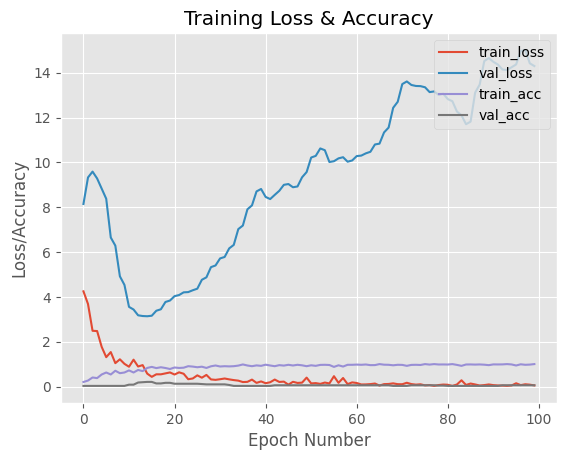

In [16]:
# Plot the training and validation loss and accuracy

plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss & Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('plot.png')